In [43]:
from random import randrange
from math import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import math


# Quantum automaton implementation

Let us consider a unary language $MOD_p=\{a^j |$ $j$ is divisible by $p\}$
We present a program realisation of an automaton for the language $MOD_p$ using an algorithm given by A.Ambainis et.al.
An idea is based on rotations of target qubit of quantum register once the automaton reads an input symbol.
The angles for rotations are $\frac{2\pi k[i]}{p}$,  where $k[i]$ are parameters, $i \in [0..d-1]$, $d$ is a number of quantum states of the register. If an input is legal, then at the end of computation the target qubit is in a state $| 0 \rangle$ with probability 1.

Let us show the implementation step by step.  
Controlnot function is a realisation of the not operation with many control qubits. This is recoursive function based on a cirquit for toffoli gate. 

<img src="iden3.png" width="90%">

In [44]:
#ccnot gate - toffoli - many qubits controlled not
#recursive function for controlnot operation with many control qubits
def controlnot(j_b,j_e,target):
        if j_e==j_b:
            qc.cx(q[j_b], q[target])
            return
        if j_e==j_b+1:
            qc.ccx(q[j_b],q[j_e], q[target])
            return
        dd=j_e-j_b #number of control qubits without q[j_e]
        qc.h(q[target])
        qc.cx(q[j_e], q[target])
        qc.tdg( q[target])
        controlnot(j_b,j_e-1,target)          
        qc.t( q[target])
        qc.cx(q[j_e], q[target])
        qc.tdg( q[target])
        controlnot(j_b,j_e-1,target)
        qc.t(q[j_e])    
        qc.t(q[target])
        qc.h(q[target])
        qc.swap(q[j_e],q[target] )  
        controlnot(j_b,j_e-1,target)
        qc.tdg(q[target])
        qc.t(q[j_e-1])
        controlnot(j_b,j_e-1,target)
        qc.swap(q[j_e],q[target] )  
       


Recursive realization of the many qubits controlled rotarion operation. The algorithm is based on a cirquit for 2 qubits controlled rotation operation, where $U = V^2$
<img src="iden2.png" width="40%">

In [45]:
def controlrotate(angle,j_b,j_e,target):
    if j_e==j_b:
        qc.cry(angle,q[j_b],q[target])
    else:   
        qc.cry(angle/2,q[j_e],q[target]) #controlrotate
        controlnot(j_b,j_e-1,j_e)
        qc.cry(-angle/2,q[j_e],q[target])
        controlnot(j_b,j_e-1,j_e)
        controlrotate(angle/2,j_b,j_e-1,target)

 n-bit Gray Codes generator is given below. The code was taken from https://www.geeksforgeeks.org/generate-n-bit-gray-codes/

In [82]:
def generateGrayarr(n):
 
    # base case
    if (n <= 0):
        return
 
    # 'arr' will store all generated codes
    arr = list()
 
    # start with one-bit pattern
    arr.append("0")
    arr.append("1")
 
    # Every iteration of this loop generates
    # 2*i codes from previously generated i codes.
    i = 2
    j = 0
    while(True):
 
        if i >= 1 << n:
            break
     
        # Enter the previously generated codes
        # again in arr[] in reverse order.
        # Nor arr[] has double number of codes.
        for j in range(i - 1, -1, -1):
            arr.append(arr[j])
 
        # append 0 to the first half
        for j in range(i):
            arr[j] = "0" + arr[j]
 
        # append 1 to the second half
        for j in range(i, 2 * i):
            arr[j] = "1" + arr[j]
        i = i << 1
 
    #print contents of arr[]
    #for i in range(len(arr)):
    #    print(arr[i])
    return arr
#generateGrayarr(2)

In [83]:
# this function gets an index of different digits in neighbouring Grey codes number i and i-1
# i is a number of the code
# n is a length of the code
def changedDigitInGreyCode(i,n,listofcodes):
    if i<=0:
        return -1
    for j in range(n):
        if listofcodes[i][j] != listofcodes[i-1][j]:
            return j
print('digit is ', changedDigitInGreyCode(0,4,generateGrayarr(4)))

digit is  -1


For each quantum state j in [0..d-1] reading one symbol the automaton rotates the target qubit on an angle[j]= 2*pi*k[j]/p, where k[j] is a parameter depending on j.

A function zeros_to_ones(num) takes an index of a state (num) as a parameter. For the state = num, the qubits (except the target qubit) go to the state '11..11'. Then the control rotation is applied for all states.
To optimize the size of the circuit we apply rotations in a specific order of states. Such an order allows to change a state by applying only one x-gate. For this optimization purpose, we use Grey codes. 


In [84]:
#let we think that num=q.register, then if there is a zero in num, we change a qubit, and register becomes 111...1 
#def zeros_to_ones(num):
#    binnum=bin(num)
#    for i in range(2,len(binnum)):
#        if binnum[i]=='0':
#            qc.x(q[i-2])
#    for i in range(len(binnum)-2,target):
#        qc.x(q[i])

#reversed operation to zeros_to_ones
#def zeros_to_ones_back(num):
#    zeros_to_ones(num)
    
#control rotation. control qubits q[0]..q[nqubits-2], target qubit q[nqubits-1]
#def ccccccrotation(dim,angle,target):
#    for num in range(dim): #for each state num in {0..d-1}
#        zeros_to_ones(num) #if num=1001 then if state is 1001, then redister becomes 1111, else register !=1111
#        controlrotate(angle[num],0,target-1,target) #apply control rotation
#        zeros_to_ones_back(num)
        
def xForGrey(digit):
    if digit >=0:
        qc.x(q[digit])
    
def xForAllQubits():
    for i in range(0,nqubits-1):
            qc.x(q[i])

    
#control rotation. control qubits q[0]..q[nqubits-2], target qubit q[nqubits-1] ,
#where states are given in order of Grey Codes
def ccccccrotationWithGreyCodes(nqubits,angle,target):
    for num in listGreyCodes: #for each state num in {0..d-1}
        digit=changedDigitInGreyCode(int(num, 2),nqubits-1,listGreyCodes)
        xForGrey(digit) #if num=1001 then if state is 1001, then register becomes 1111, else register !=1111
        controlrotate(angle[int(num, 2)],0,target-1,target) #apply control rotation
    qc.x(q[0]) #back to the state '00..00' from the last state '100.000' in order of Grey codes



# The body of the automaton.
Ambainis and Nakhimovs proposed that the required amount of state for the error probability eps is $d=\frac{4 \log 2p}{eps}$. Hense, a number of qubits is $\log d+1$, $\log d$ qubits are needed to form d different states, one another qubit is a target qubit.

In [85]:
p= int(input('write p='))
#eps=float(input('write eps='))
eps=0.2
print("let us compute w mod p!")


#angle = 2*pi*k[i]/p
d=math.ceil(4*math.log(2*p,2)/eps)
nqubits=math.ceil(math.log(d,2))+1
print('number of qubits really needed=', nqubits)
#temporarily!!!!!!
nqubits=4 #let us set a number of qubits by 4, just for fast testing. Indeed, we use nqubits=log d, where d=4 log 2p/ eps
print('d=', d)
print('number of qubits=', nqubits)
d=2**(nqubits-1)
print("new d=",d)

write p=5
let us compute w mod p!
number of qubits really needed= 8
d= 67
number of qubits= 4
new d= 8


The algorithm requires an appropriate set of coefficients k_1..k_d.  The parameters k_1..k_d finding algorithm is presented below. We also use a list of parameters as a key in an algorithm for digital signature.

In [86]:
#parameters k_1..k_d finding
import numpy.matlib
import numpy as np
from scipy import linalg

gamma =eps

kk=d
q=p
t = eps/2
dd=p

def f(h):
    perm = [*range(h,q)] + [*range(0,h)]
    ph = np.eye(q)[perm, :]
    perm1 = [*range(q-h,q)] + [*range(0,q-h)]
    ph1 = np.eye(q)[perm1, :]
    return np.matmul(np.eye(q) - np.ones((q,q))/q, ph+ph1)/2

def sfx(xs):
    s = np.zeros((q,q))
    for i in xs:
        s = s + f(i)
    return s

def efx():
    s = np.zeros((q,q))
    for i in range(0,q):
        s = s + linalg.expm(t * f(i))
    s = s/q
    es = linalg.eig(s)
    return np.max(np.abs(es[0]))

meanefx = efx()
def phi(xs):
    tr = 2*dd        
    if len(xs) > 0:
        s = sfx(xs)
        tr = np.trace(linalg.expm(t * s))
    return dd * np.exp(-t * gamma * kk) * tr * pow(meanefx, kk-len(xs))

result = list()
if phi(result) >= 1:
    print("Bad parameters: 1 <= phi_0 = ", phi(result)) 
for i in range(0, kk):
    y = result.copy()
    y.append(0)
    miny = y.copy()
    for j in range(0,q):
        y[i] = j
        if phi(y) < phi(miny):
            miny = y.copy()
    if phi(miny) > phi(result):
        print("Impossible happened: phi_i=" + str(phi(miny)) + " > phi_{i-1}=" + str(phi(result)))
        print(str(result))
        print(str(miny))
    result = miny
    print("i=" + str(i) + "; phi=" + str(phi(result)))
    result
    
print("x=" + str(result))
eigs = linalg.eig(sfx(result)/kk)
#print("norm=" + str(np.max(np.abs(eigs[0]))))
#print("q=",q)
#print("d=", d)
print(len(result))
x=result

Bad parameters: 1 <= phi_0 =  43.46737083474938
i=0; phi=21.277675826737735
i=1; phi=20.78161066244019
i=2; phi=20.34947666020653
i=3; phi=19.87943184788696
i=4; phi=19.469898429355965
i=5; phi=19.024484187377265
i=6; phi=18.63634456270474
i=7; phi=18.21424546625168
x=[1, 2, 1, 2, 1, 2, 2, 1]
8


For simplicity, let us consider an input string w as an integer that is processed as a flow.

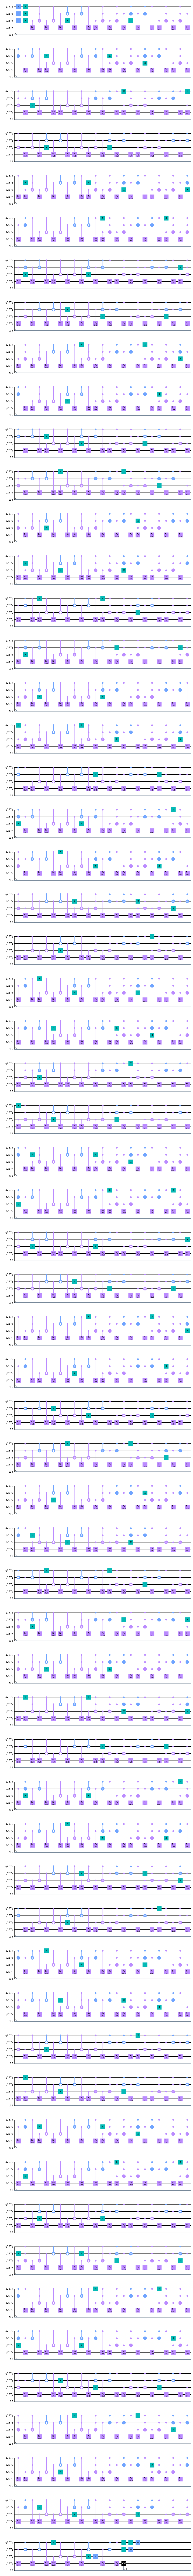

{'1000': 35, '0000': 65}
21 mod 5 !=0


In [87]:
q =  QuantumRegister(nqubits) 
c = ClassicalRegister(nqubits) 
qc = QuantumCircuit(q,c)

w=21
#input number         
#w=int(input('write an input w='))

target=nqubits-1
#k=[1, 2, 3, 0, 4]
angle=[]
k=x
listGreyCodes=generateGrayarr(nqubits-1)

for i in range(d):
    angle.append(2*2*pi*k[i]/p)

for i in range(target):
    qc.h(q[i])
    
#processing the input string
xForAllQubits()
for i in range (w):
    ccccccrotationWithGreyCodes(nqubits,angle,target)
    
xForAllQubits()
    
for i in range(target):
    qc.h(q[i])

    
qc.measure(q[target],c[target])
display(qc.draw(output="mpl")) 

job = execute(qc,Aer.get_backend('qasm_simulator'),shots=100)

# print the results

counts = job.result().get_counts(qc)
print(counts)
answer = counts.most_frequent()[0]
if len(counts)==1 and answer=='0':
    print(w, "mod", p, "=0")
else:
    print(w, "mod", p, "!=0")


# Digital signature

Alice has a binary string as a message, compute a digital signature and sends the message and the signature to Bob. 

Bob has keys $k_1k_2 \cdots k_d$ for checking whether the message is authentic (right).

A signature is a quantum register that was changed by Alice in a way presented above. For transformation of the register Alice uses an algorithm of automaton for the language MOD_p, where p is big enough and a set of parameters $k_1k_2 \cdots k_d$ can be chosen as a key. We randomly picked these numbers for convenience. 
Namely, she applies transformations on a quantum register that is initially in a state '000...0'.
Firstly, she obtains a superposition of states applying Hadamard to all qubits excepting target qubit 
Then, reading digit "1" in a message Alice rotates qubits on different angles, there is specific angle for each state.
After proccessing the message, she sends the register and the message to Bob.

On a side, Bob reading the message, applies  inverted rotations to the qubits. He knows parameters $k[i]$ as keys. At the end, applies Hadamard operation and measures the target qubit.
If outcomes are allways zeroes for all shots, then the message is authentic.
If some outcomes are ones, then the message was intercepted and corrupted.

In [ ]:
alice_message_text=input("Alice, write your message, please: ")
#we convert a text to a binary string
alice_message = ''.join(format(ord(i), '08b') for i in alice_message_text)
print('binary_message=', alice_message)
p=len(alice_message)+1
eps=0.2
d=math.ceil(2*math.log(2*p,2)/eps)
nqubits=math.ceil(math.log(d,2))+2

#temp!!!!!!
nqubits=4
print('number of qubits=', nqubits)
d=2**(nqubits-1)



In [ ]:
q =  QuantumRegister(nqubits) 
c = ClassicalRegister(nqubits) 
qc = QuantumCircuit(q,c)

k=[]
target=nqubits-1
angle=[]
#for simplicity we construct a key from random ints
for i in range(d):
    k.append(randrange(d))

for i in range(d):
    angle.append(2*2*pi*k[i]/p)

for i in range(target):
    qc.h(q[i])
    
#processing the input string
for i in range (len(alice_message)):
    if alice_message[i]=='1':
        ccccccrotationWithGreyCodes(nqubits,angle,target)
    
print(len(alice_message))

Alice gives an  access to the register to Bob. Bob also knows the list $k$. We omit the part of sending this information and give only algorithms of using signature.
Bob makes his job evaluating the quantum system.

In [ ]:
#processing the input string
#there should be a message sending peocedure. We assume that Bob received bob_message from Alice via some classical channel, 
# and quantum register was sent through a quantum channel


eva=input("Will Eva intercept Alice's message? yes/no: ")
if eva=="yes":
    eva_message_text=input("Write Eva's message: ")
    
    eva_message = ''.join(format(ord(i), '08b') for i in eva_message_text)
    bob_message=eva_message
else:
    bob_message=alice_message
#for test let us use eva_message
#eva_message="01000111"
#bob_message=eva_message

angleBob=[]
for i in range(d):
    angleBob.append(-2*2*pi*k[i]/p)

for i in range (len(bob_message)):
    if bob_message[i]=='1':
        ccccccrotation(d,angleBob,target)

for i in range(target):
    qc.h(q[i])

qc.measure(q[target],c[target])
job = execute(qc,Aer.get_backend('qasm_simulator'),shots=100)

# print the results
counts = job.result().get_counts(qc)
print(counts)
answer = counts.most_frequent()[0]
if len(counts)==1 and answer=='0':
    print("the message is right")
else:
    print("the message was corrupted")